In [6]:
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)
import numpy as np
from databases.sql_connect import create_connection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
from databases.sql_connect import create_connection
import matplotlib.font_manager as font_manager
from decimal import Decimal
import matplotlib

# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "Times New Roman"
sns.set_theme(font_scale=1)
sns.set(context="paper", style="darkgrid", font="Times New Roman")
cm = 1/2.54
DB_CORR = os.path.join(parent,"databases", "TEMPRO_DB230515_Corr.db")
assert(os.path.exists(DB_CORR))



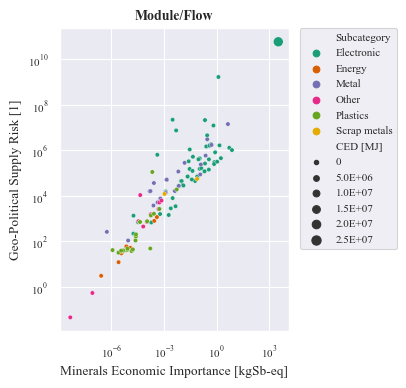

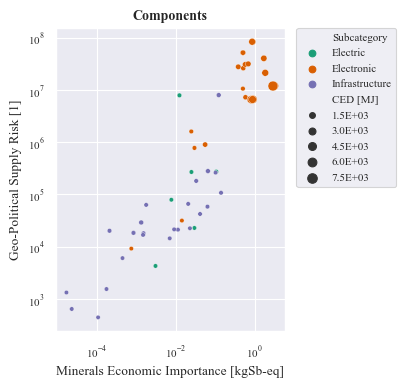

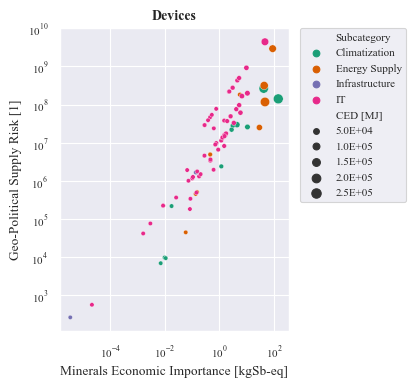

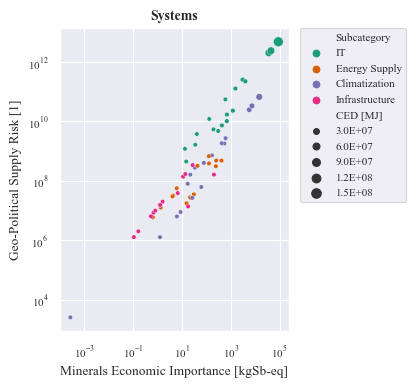

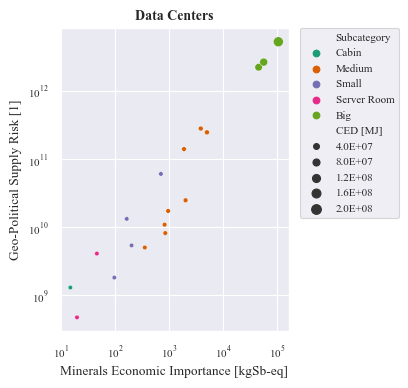

In [8]:

def create_chart_indicators(group= 3000, x="EI-Minerals- Total",y = "GPR-Minerals- Total", z="CED - total"):
    # Connection and queries for the data base
    conn = create_connection(DB_CORR)
    query = f'SELECT * FROM [{group}LCAResults]'
    df = pd.read_sql_query(query, conn)
    query_subcats = 'SELECT * FROM [B:Subcategories]'
    df_subcats = pd.read_sql_query(query_subcats, conn)
    conn.close()

    # Get the indicators
    df_subcats.set_index("ID", inplace=True)
    df_adp = df[df["Category"] == x]
    df_gpr = df[df["Category"] == y]
    df_ced = df[df["Category"] == z]

    df_impact_names=pd.read_csv("impacts_names.csv")
    df_impact_names.set_index("Name",inplace=True)
    label_x = df_impact_names.loc[x,"LongName"] + " [" +   df_impact_names.loc[x,"Unit"]+"]"
    label_y = df_impact_names.loc[y,"LongName"] + " [" +   df_impact_names.loc[y,"Unit"]+"]"
    label_z = df_impact_names.loc[z,"LongName"] + " [" +   df_impact_names.loc[z,"Unit"]+"]"

    for df in [df_adp, df_gpr, df_ced]:
        df.set_index("ProductSystemID", inplace=True)

    agregated_res = pd.DataFrame()
    agregated_res[label_x] = np.nan
    agregated_res[label_y] = np.nan
    agregated_res[label_z] = np.nan
    agregated_res["Subcategory"] = np.nan

    for i in df_ced.index:
        agregated_res.loc[i, label_x] = df_adp.loc[i, "Result"]
        agregated_res.loc[i,label_y] = df_gpr.loc[i, "Result"]
        agregated_res.loc[i, label_z] = df_ced.loc[i, "Result"]
        subcat_num = i - i % 100
        if subcat_num==6000:
            subcat_num=6100
        agregated_res.loc[i, "Subcategory"] = df_subcats.loc[subcat_num,"Name"]
    if label_z=="Primary Energy [MJ-eq]":
        agregated_res.rename(columns={label_z:"CED [MJ]"}, inplace=True)
        label_z="CED [MJ]"
    agregated_res=agregated_res[agregated_res["Subcategory"]!="Process"]
    agregated_res=agregated_res[agregated_res["Subcategory"]!="Balancing Flows"]
    agregated_res=agregated_res[agregated_res["Subcategory"]!="Recycling Inputs"]

    fig,ax = plt.subplots(figsize=(7.5*cm,10*cm))

    # Special for the data center category to plot sizes
    if group == 6000:
        size_data = pd.read_excel("results_eval.xlsx", engine="openpyxl", sheet_name="Power")
        size_data.set_index("ID", inplace=True)
        for idx, rows in agregated_res.iterrows():
            agregated_res.at[idx,"Subcategory"]=size_data.at[idx,"Category"]

    sns.scatterplot(ax=ax,data=agregated_res, x=label_x, y=label_y, hue="Subcategory", size = label_z, sizes=(10,50), palette="Dark2")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    font = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=8)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8,prop=font)
    handles, labels = ax.get_legend_handles_labels()
    for i,l in enumerate(labels):
        try:
            number = int(l)
            if number >0:
                labels[i] = '%.1E' % Decimal(number)
        except:
            pass
    ax.legend(handles, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8,prop=font)
   
    plt.xscale('log')
    plt.yscale('log')

    titles = {
        2000:"Module/Flow",
        3000:"Components",
        4000: "Devices",
        5000: "Systems",
            6000:"Data Centers"}
    ax.set_title(titles[group], fontweight= "bold", fontsize= 10)
    
    fig.savefig(f"ChartsImpacts/{group},{x},{y},{z}.svg",bbox_inches='tight', dpi=600)

for i in [2000,3000,4000,5000,6000]:
    create_chart_indicators(group=i)